# Machine Learning Engineer Nanodegree
## Capstone Project
## Project: Predicting liver disease from data

## Introduction

The aim of this project is to choose and train a machine learning algorithm that will be trained to predict a liver disease in patients.

The dataset for this problem is the ILPD (Indian Liver Patient Dataset) taken from the UCI Machine Learning Repository . Number of instances are 583. It is a multivariate data set, contain 10 variables that are age, gender, total Bilirubin, direct Bilirubin, total proteins, albumin, A/G ratio, SGPT, SGOT and Alkphos. All values are real integers. This data set contains 416 liver patient records and 167 non liver patient records.The data set was collected from north east of Andhra Pradesh, India. Selector is a class label used to divide into groups(liver patient or not). This data set contains 441 male patient records and 142 female patient records. Any patient whose age exceeded 89 is listed as being of age "90".

----
## Exploring the Data
Below, we will load the ILPD data. The dataset taken from UCI Repository has been slightly modified. Headings have been introduced to each column. The last column, `'Disease'`, is the label (with '1' representing presence of disease and '2' representing absence of disease).

In [55]:
# We will need following libraries
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # So that display() can be used for Dataframe
import visuals as vs
%matplotlib inline

# Loading the ILPD dataset
data = pd.read_csv("ILPD.csv")

print "No of samples: {}. No of features in each sample: {} .".format(*data.shape)
# Display the first  5 records
display(data.head(n=5))

#some statistics about the data
display(data.describe())

No of samples: 583. No of features in each sample: 11 .


,Age,Gender,Total Bilirubin,Direct Bilirubin,Total Proteins,Albumin,A/G ratio,SGPT,SGOT,Alkphos,Disease
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


,Age,Total Bilirubin,Direct Bilirubin,Total Proteins,Albumin,A/G ratio,SGPT,SGOT,Alkphos,Disease
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,NaN,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,NaN,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,NaN,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


----
## Preprocessing Data
In the description of this dataset, it is observed that some values are ‘Null’ for the ‘Álkphos’ column. Accordingly, those rows are removed. 

In [56]:
# We can see that the column 'Alkphos' has 4 missing values
alkphos=data['Alkphos']
print "length before removing NaN values:%d"%len(data)
data = data[pd.notnull(data['Alkphos'])]
print "length after removing NaN values:%d"%len(data)

length before removing NaN values:583
length after removing NaN values:579


### Log transform certain features
After removing the column ‘Disease’ from the dataset as it is the label, we display all features in a histogram format to check if any feature is skewed ( contains a small number of outlier values). Skewed features found are Albumin, Direct Bilirubin, A/G ratio, Total Bilirubin, Total Protein. On these, a log transformation is applied to reduce their range.

C:\Users\dinkar\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A11BAC8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000C11A668>]], dtype=object)

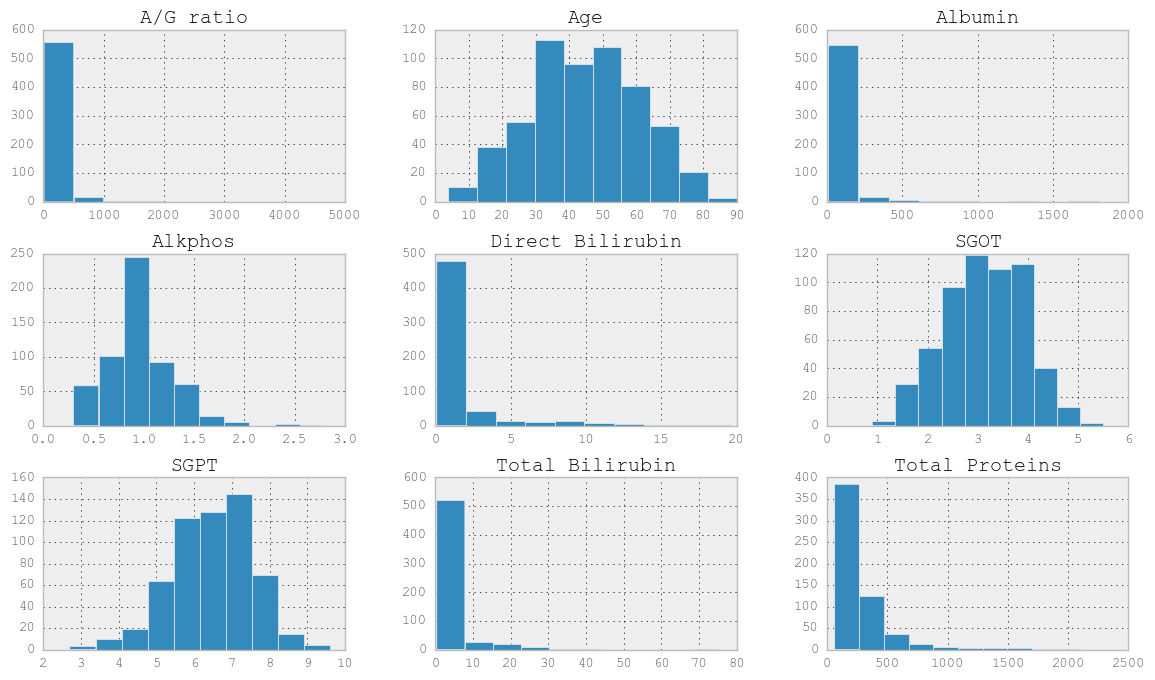

In [3]:
# Split the data into features and target label(disease)
disease_initial = data['Disease']
features_initial = data.drop('Disease', axis = 1)

# Visualize skewed continuous features of original data
import matplotlib.pyplot as plt
pd.options.display.mpl_style = 'default'
features_initial.hist(figsize=(14,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010A7A1D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000EF41668>]], dtype=object)

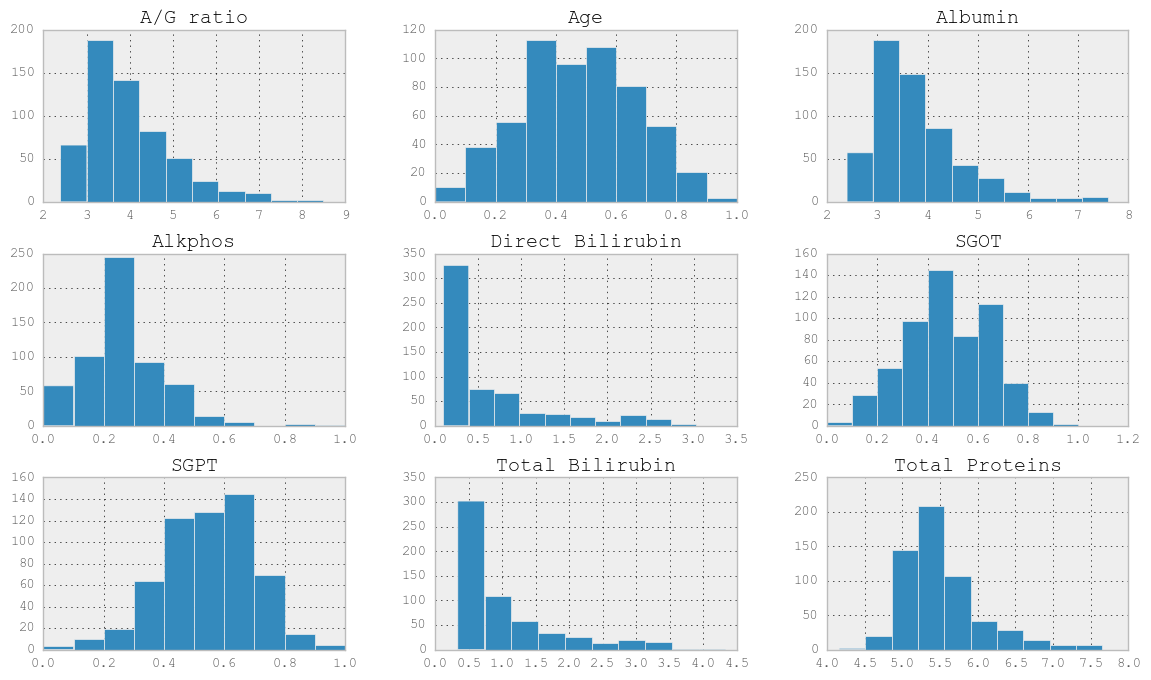

In [57]:
# Skewed features are Albumin, Direct Bilirubin, A/G ratio, Tota Bilirubin, Total Protein 
#Log-transform the skewed features
skewed = ['Albumin', 'Direct Bilirubin', 'Total Bilirubin', 'A/G ratio', 'Total Proteins']
features_initial[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
features_initial.hist(figsize=(14,8))


Thereafter, all columns in the dataset except ‘Gender’ are normalized. We use MinMaxScaler here as StandardScaler gives very low values here, with some in the order of 10-16, which might be difficult to relate to and visualize.

In [58]:
# Import sklearn.preprocessing.StandardScaler- producing  values in range of 10^-16
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()

normalized = ['Age', 'SGPT', 'SGOT', 'Alkphos', 'Albumin', 'Direct Bilirubin', 'Total Bilirubin', 'A/G ratio', 'Total Proteins']
skewed = ['Albumin', 'Direct Bilirubin', 'Total Bilirubin', 'A/G ratio', 'Total Proteins']
features_initial[normalized] = scaler.fit_transform(data[normalized])

# Show an example of a record with scaling applied
display(features_initial.describe())

,Age,Total Bilirubin,Direct Bilirubin,Total Proteins,Albumin,A/G ratio,SGPT,SGOT,Alkphos
count,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000
mean,0.474214,0.039080,0.071129,0.111561,0.035742,0.020414,0.548071,0.486634,0.258826
std,0.188625,0.083481,0.143699,0.118985,0.092052,0.058925,0.157194,0.172703,0.127837
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.337209,0.005362,0.005102,0.054958,0.006533,0.003049,0.449275,0.369565,0.160000
50%,0.476744,0.008043,0.010204,0.070835,0.012563,0.006505,0.565217,0.478261,0.252000
75%,0.627907,0.029491,0.061224,0.114802,0.025628,0.015654,0.652174,0.630435,0.320000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### One-Hot Encoding

Then we use pd.get_dummies() method to one-hot encode the feature ‘Gender’ as well as the label ‘Disease’ ( with the integer ‘1’ representing presence of disease).
The dataset will be split into training and testing set as a 80-20 split using train_test_split method from sklearn. Random state will be specified as a particular number so that we have a means for comparison later.

In [60]:
# TODO: One-hot encode the data using pandas.get_dummies()
features = pd.get_dummies(features_initial)

encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))
print encoded
display(features.head(n = 1))

disease=pd.get_dummies(disease_initial)
encoded = list(disease.columns)
print "{} disease columns after one-hot encoding.".format(len(encoded))
#print disease[1]
display(disease.head(n = 1))

11 total features after one-hot encoding.
['Age', 'Total Bilirubin', 'Direct Bilirubin', 'Total Proteins', 'Albumin', 'A/G ratio', 'SGPT', 'SGOT', 'Alkphos', 'Gender_Female', 'Gender_Male']


,Age,Total Bilirubin,Direct Bilirubin,Total Proteins,Albumin,A/G ratio,SGPT,SGOT,Alkphos,Gender_Female,Gender_Male
0,0.709302,0.004021,0.0,0.060576,0.003015,0.001626,0.594203,0.521739,0.24,1.0,0.0


2 disease columns after one-hot encoding.


,1,2
0,1.0,0.0


In [61]:
# Import train_test_split
from sklearn.cross_validation import train_test_split, ShuffleSplit

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, disease[1], test_size = 0.2, random_state = 7)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 463 samples.
Testing set has 116 samples.


----
## Evaluating Model Performance

Before applying any supervised learning technique, we will implement a naïve predictor, that will simply return that every data point has ‘Disease’= True. We will check our accuracy on that predictor.

Then, we will use F-beta score as another metric, where-

F-beta score = (1+beta*beta)*precision*recall/((beta*beta*precision)+recall

Precision=TP/ (TP+FP), Recall=TP/ (TP+FN)

TP=True Positive

FP=False Positive

FN=False Negative

Beta= A number that decides relative weightage of precision and recall. In this case, a disease being classified as a non-disease will incur a high penalty. So, more emphasis is placed on recall.


In [62]:
#naive accuracy, assuming that we predict everyone has disease
positive_disease=len(data[data['Disease'] == 1])
print positive_disease
accuracy = positive_disease*1.0/len(data)
precision=accuracy
recall=1
beta=2# assuming beta to be 2, giving greater weightage to recall
fscore = (1+beta*beta)*precision*recall/((beta*beta*precision)+recall)
# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

414
Naive Predictor: [Accuracy score: 0.7150, F-score: 0.9262]


In [9]:
# Here I use some portions of the codebase of the MLND supervised learning project 'finding_donors'
from sklearn.metrics import fbeta_score, accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    results = {}

    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    results['train_time'] = end - start
        
    start = time() 
    predictions_test = learner.predict(X_test)# predictions on test set
    predictions_train = learner.predict(X_train[:200])# predictions on first 200 elements of training set
    end = time()
    
    results['pred_time'] = end - start
            
    results['acc_train'] = accuracy_score(y_train[:200],predictions_train)
        
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    results['f_train'] = fbeta_score(y_train[:200],predictions_train,beta=2)
        
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=2)
       
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    return results

### Supervised Learning Approach
Thereafter, we will use these supervised learning approaches for this problem:
1. Logistic Classification: Since the outcome is binary and we have a reasonable number of examples at our disposal compared to number of features, this approach seems suitable. At the core of this method is a logistic or sigmoid function that quantifies the difference between each prediction and its corresponding true value.                                                                  
2. Support Vector Machine:   SVM aims to find an optimal hyperplane that separates the data into different classes.                                  
3. Random Forest Classifier: It comes under the category of ensemble methods. It employs ‘bagging’ and ‘boosting’ methods to draw a random subset from the data, and train a Decision Tree on that.                                                           4.k Nearest Neighbors: It uses the k closest neighbors of a data point to determine which class should that data point belong to.


LogisticRegression trained on 463 samples.
Performance metrics for benchmark model (Logistic regression):
Accuracy score on training subset:0.70
Accuracy score on test subset:0.75
F-score on training subset:0.91
F-score on test subset:0.91
RandomForestClassifier trained on 92 samples.
RandomForestClassifier trained on 231 samples.
RandomForestClassifier trained on 463 samples.
SVC trained on 92 samples.
SVC trained on 231 samples.
SVC trained on 463 samples.
KNeighborsClassifier trained on 92 samples.
KNeighborsClassifier trained on 231 samples.
KNeighborsClassifier trained on 463 samples.


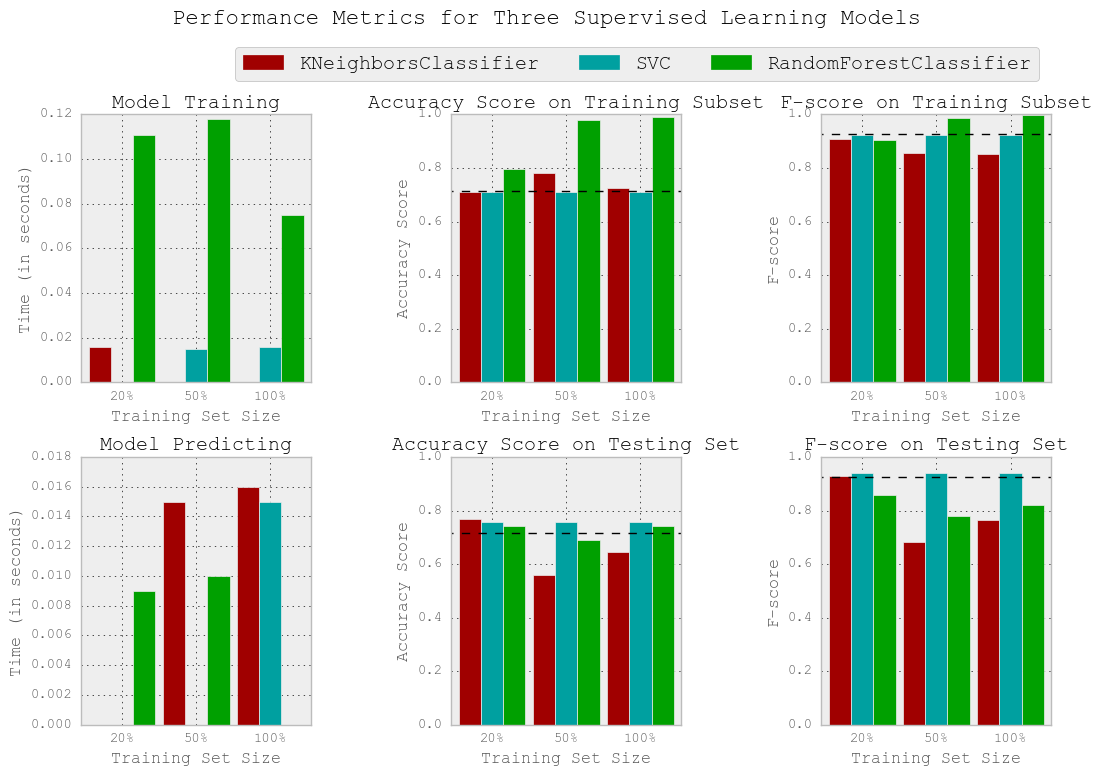

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# TODO: Initialize the three models

clf_base = LogisticRegression(random_state=7)
clf_A = RandomForestClassifier(random_state=7)
clf_B = SVC(random_state=7)
clf_C = KNeighborsClassifier()

# TODO: Calculate the number of samples for 20%, 50%, and 100% of the training data
samples_20 = int(len(X_train) * 0.2)
samples_50 = int(len(X_train) * 0.5)
samples_100 = int(len(X_train) )
result_1={}
result_1=train_predict(clf_base, samples, X_train, y_train, X_test, y_test)
print 'Performance metrics for benchmark model (Logistic regression):'
print 'Accuracy score on training subset:%.2f'%result_1['acc_train']
print 'Accuracy score on test subset:%.2f'%result_1['acc_test']
print 'F-score on training subset:%.2f'%result_1['f_train']
print 'F-score on test subset:%.2f'%result_1['f_test']
# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_20, samples_50, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Visuals borrowed from 'finding_donors' project
vs.evaluate(results, accuracy, fscore)

### ROC Curve

An additional metric called as Receiver Operator Characteristics(ROC) curve will be used. It plots the curve of True Positive Rate vs the False positive Rate, with a greater area under the curve indicating a better True Positive Rate for the same False Positive Rate. This can be helpful in this case as simply knowing the number of correct predictions may not suffice.
  



For classifier RandomForestClassifier, ROC score is 0.659091


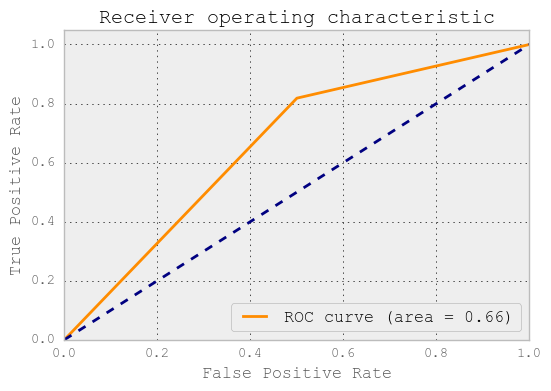

For classifier SVC, ROC score is 0.500000


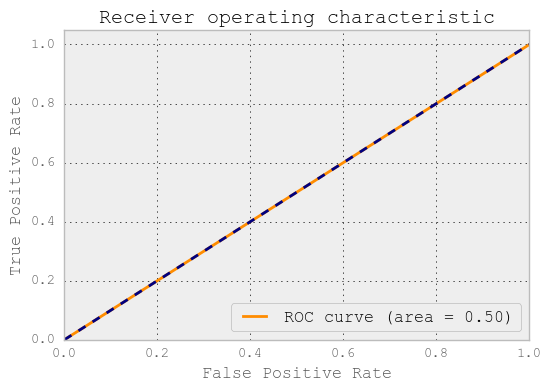

For classifier KNeighborsClassifier, ROC score is 0.523539


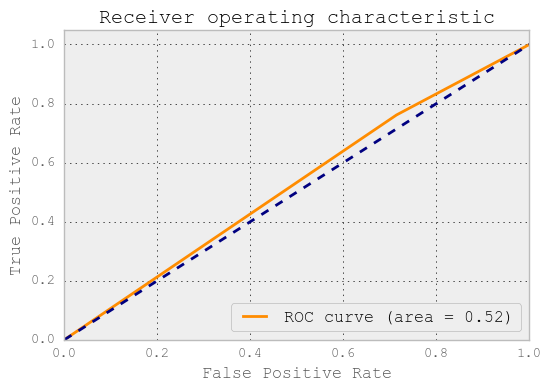

In [53]:
#plotting ROC curve

for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    pred=clf.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    print "For classifier %s, ROC score is %f"%(clf_name,roc_auc)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
#fpr, tpr, thresholds = roc_curve(y, scores, pos_label=2)

### Fine Tuning the Models
Now we will use the grid search method to see if we can improve the performance of various models with different values for the given hyperparameters. 


For classifier RandomForestClassifier:
Unoptimized model
------
Accuracy score on testing data: 0.7414
F-score on testing data: 0.8219

Optimized Model
------
Final accuracy score on the testing data: 0.7500
Final F-score on the testing data: 0.8686
Best parameters:
{'max_features': None, 'n_estimators': 15, 'oob_score': False, 'max_depth': 3}
For classifier RandomForestClassifier, ROC score is 0.603896


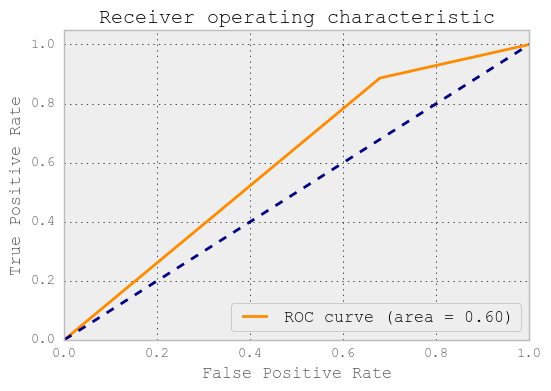


---------------------------------X----------------------------

For classifier SVC:
Unoptimized model
------
Accuracy score on testing data: 0.7586
F-score on testing data: 0.9402

Optimized Model
------
Final accuracy score on the testing data: 0.7586
Final F-score on the testing data: 0.9402
Best parameters:
{'kernel': 'poly', 'C': 0.001}
For classifier SVC, ROC score is 0.500000


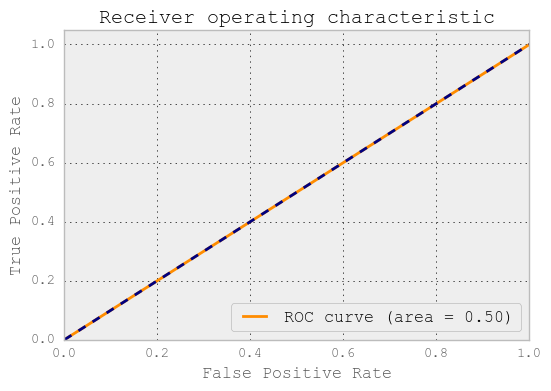


---------------------------------X----------------------------

For classifier KNeighborsClassifier:
Unoptimized model
------
Accuracy score on testing data: 0.6466
F-score on testing data: 0.7631

Optimized Model
------
Final accuracy score on the testing data: 0.6552
Final F-score on the testing data: 0.7960
Best parameters:
{'n_neighbors': 15, 'weights': 'uniform'}
For classifier KNeighborsClassifier, ROC score is 0.492695


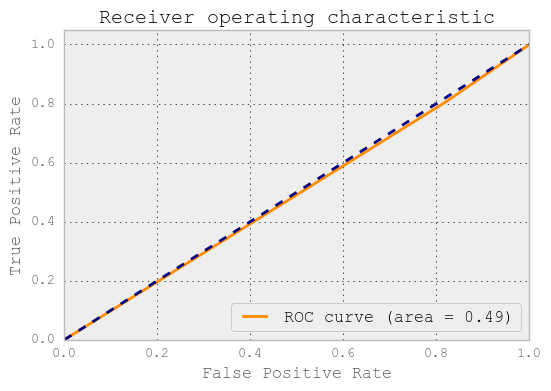


---------------------------------X----------------------------



In [65]:

from sklearn.metrics import roc_curve,auc
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
# TODO: Initialize the classifier
i=0
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    print 'For classifier %s:'%(clf_name)
    if i==0: #RandomForest
        parameters = {'max_features':['auto',None],# 'auto' option uses square root of number of features
                     'oob_score':[False,True],# setting it to 'True' saves the generalization error
                     'max_depth':[3,10,15],# depth of tree
                     'n_estimators':[3,10,15]}# number of trees
    elif i==1: #SVM
        parameters={'kernel':['poly','rbf','linear'],# different ways to separate data pts by a hyperplane
                    'C':[0.001,1,1000]} # weight of penalty assigned to error
    elif i==2: #kNearestClassifier
        parameters={'n_neighbors':[5,10,15],# number of neighbors
                    'weights':['uniform','distance']}# distance means weights are inversely proportional to distance

    scorer = make_scorer(fbeta_score, beta=2)
    grid_obj = GridSearchCV(clf,parameters,scoring=scorer)
    grid_fit = grid_obj.fit(X_train,y_train)
    best_clf = grid_fit.best_estimator_

    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)
    # Report the before-and-afterscores
    print "Unoptimized model\n------"
    print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
    print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 2))
    print "\nOptimized Model\n------"
    print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
    print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 2))
    print "Best parameters:"
    print grid_fit.best_params_
    fpr, tpr, _ = roc_curve(y_test, best_predictions)
    roc_auc = auc(fpr, tpr)
    print "For classifier %s, ROC score is %f"%(clf_name,roc_auc)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print "\n---------------------------------X----------------------------\n"
    i+=1

### Conclusion-Final Model Evaluation
As the results show, it is difficult to arrive at a clear-cut answer for the best performing model among SVM and Random Forest. While SVM shows better result in terms of F-beta score (0.94), its area under the ROC curve is surprisingly low. Random Forest shows a decent enough F-beta score (0.87) and its area under ROC curve is 0.6. So, I will pick Random Forest as the best algorithm, even though its performance  after Grid Search is just at par with the benchmark model of Logistic Regression, maybe because of paucity of data points.